In [1]:
import sys
sys.path.append('../')

In [2]:
from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates import *

/home/dmai/miniconda3/envs/mrl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [3]:
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models import *
from mrl.agent import *
from mrl.vocab import *
from mrl.callbacks import *
from mrl.callbacks.template_cb import *
from mrl.agent import *
from mrl.policy_gradient import *
from mrl.loss import *
from mrl.sampler import *
from mrl.environment import *
from mrl.reward import *

In [4]:
os.environ['ncpus'] = '0'
torch.cuda.set_device(1)
# set_global_pool(cpus=8)

## Reward Function

In [5]:
df = pd.read_csv('../nbs/untracked_files/affinity_data.csv')
df = df[df.smiles.map(lambda x: not '.' in x)]

In [6]:
reward_model = MLP_Encoder(2048, [1024, 512, 256, 128], 1, [0.2, 0.2, 0.2, 0.2])
r_ds = Vec_Prediction_Dataset(df.smiles.values, df.value.values/10, ECFP6)
r_agent = PredictiveAgent(reward_model, MSELoss(), r_ds, opt_kwargs={'lr':1e-3})

In [7]:
r_agent.train_supervised(32, 12, 1e-3, percent_valid=0.1)

Epoch,Train Loss,Valid Loss,Time
0,0.17009,0.15867,00:08
1,0.13449,0.13572,00:07
2,0.04716,0.04434,00:07
3,0.09222,0.05951,00:07
4,0.06012,0.03653,00:07
5,0.04333,0.02593,00:07
6,0.05999,0.02924,00:07
7,0.02261,0.02106,00:07
8,0.02450,0.02146,00:07
9,0.03441,0.03295,00:07


In [8]:
r_agent.save_weights('../nbs/untracked_files/affinity_mlp.pt')

In [9]:
# validate

_, valid_ds = r_ds.split(0.1)

valid_dl = valid_ds.dataloader(256, num_workers=0, shuffle=False)
r_agent.model.eval();

preds = []
targs = []

with torch.no_grad():
    for i, batch in enumerate(valid_dl):
        batch = to_device(batch)
        x,y = batch
        pred = r_agent.model(x)
        preds.append(pred.detach().cpu())
        targs.append(y.detach().cpu())
        
preds = torch.cat(preds).numpy()
targs = torch.cat(targs).numpy()

Text(0.9, 0.2, 'R-squared = 0.85')

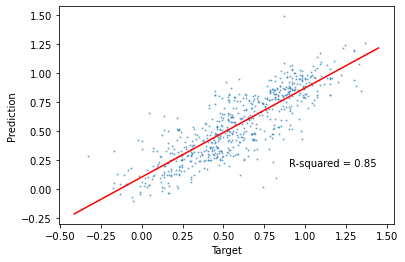

In [10]:
fig, ax = plt.subplots()

ax.scatter(targs, preds, alpha=0.5, s=1)
plt.xlabel('Target')
plt.ylabel('Prediction')

slope, intercept = np.polyfit(targs, preds, 1)
ax.plot(np.array(ax.get_xlim()), intercept + slope*np.array(ax.get_xlim()), c='r')

ybar = targs.sum()/len(targs)
ssreg = ((preds-ybar)**2).sum()
sstot = ((targs-ybar)**2).sum()
r_sq = ssreg/sstot
plt.text(0.9, 0.2, 'R-squared = %0.2f' % r_sq)

## Generative RL

In [5]:
# def scale_sa(sa):
#     return (10-sa)/9

# template = Template([ValidityFilter(), 
#                      SingleCompoundFilter(), 
#                      RotBondFilter(None, 8),
#                      ChargeFilter(None, 0)],
#                     [QEDFilter(0.5, None, score=1.),
#                      SAFilter(None, 6, score=1.)], 
#                     fail_score=-10., log=False)

smarts = ['[#6](=[#16])(-[#7])-[#7]',
        '[H]-[#6](-[H])=[#6]-[*]',
        '[#6]=[#6]=[#6]',
        '[#7][F,Cl,Br,I]',
        '[#6;!R]=[#6;!R]-[#6;!R]=[#6;!R]']

template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     RotBondFilter(None, 8),
                     HeteroatomFilter(None, 8),
                     ChargeFilter(None, 0),
                     MaxRingFilter(None, 6),
                     MinRingFilter(5, None),
                     HBDFilter(None, 5),
                     HBAFilter(None, 10),
                     MolWtFilter(None, 500),
                     LogPFilter(None, 5),
                     SAFilter(None, 7),
                     BridgeheadFilter(None,0),
                     PAINSAFilter(),
                     ExclusionFilter(smarts, criteria='any'),
                     RotChainFilter(None, 7)
                    ],
                    [], 
                    fail_score=-10., log=False, use_lookup=True)

template_cb = TemplateCallback(template, prefilter=True)

In [6]:
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)
loss = PolicyLoss(pg, 'PPO', 
                   value_head=ValueHead(256), 
                   v_update_iter=2, 
                   vopt_kwargs={'lr':1e-3})

In [7]:
r_model = MLP_Encoder(2048, [1024, 512, 256, 128], 1, [0.2, 0.2, 0.2, 0.2])

r_ds = Vec_Prediction_Dataset(['C'], [0], partial(failsafe_fp, fp_function=ECFP6))

r_agent = PredictiveAgent(r_model, MSELoss(), r_ds, opt_kwargs={'lr':1e-3})

r_agent.load_weights('../nbs/untracked_files/affinity_mlp.pt')

r_model.eval();

freeze(r_model)

aff_reward = FunctionReward(r_agent.predict_data, 
                            'aff', 
                            weight=-10.)

### FP VAE

In [9]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Vec_To_Text_Dataset(['C'], vocab, ECFP6)
supervised_loss = VAELoss(weight=0.5)

d_vocab = len(vocab.itos)
d_embedding = 256
encoder_d_in = 2048
encoder_dims = [1024, 512]
encoder_drops = [0.1, 0.1]
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
bidir = False
condition_hidden = True
condition_output = True
bos_idx = vocab.stoi['bos']


model = MLP_VAE(
            d_vocab,
            d_embedding,
            encoder_d_in,
            encoder_dims,
            encoder_drops,
            d_hidden,
            n_layers,
            d_latent,
            input_dropout=input_dropout,
            lstm_dropout=lstm_dropout,
            condition_hidden=condition_hidden,
            condition_output=condition_output,
            prior=None,
            bos_idx=bos_idx,
            transition=None,
        )

model.z_scale = 0.1

model.load_state_dict(torch.load('../nbs/untracked_files/fp_vae_zinc.pt'))

<All keys matched successfully>

In [10]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':1e-4},
                       base_update_iter=5, base_update=.97)

In [11]:
gen_bs = 1500

sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0.6, gen_bs)
sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('rewards', 10, 95, 100)
sampler4 = TokenSwapSampler('rewards', 10, 95, 100, vocab, 0.1)

samplers = [sampler1, sampler2, sampler3, sampler4]

In [12]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [supervised_cb, live_p90, live_max]

In [13]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[aff_reward], loss_cbs=[loss],
                 cbs=cbs)

In [14]:
env.fit(200, 90, 2000, 10)

iterations,rewards,template,valid,diversity,bs,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
0,-8.491,0.000,0.650,1.000,130,1.000,0.417,-8.589,1.000,-8.491,0.355,-6.779,-4.989
10,-8.349,0.000,0.680,1.000,136,1.000,0.467,-8.231,1.000,-8.349,0.191,-6.892,-5.223
20,-8.151,0.000,0.620,1.000,124,1.000,0.367,-8.234,1.000,-8.151,0.242,-7.007,-5.848
30,-7.970,0.000,0.625,1.000,125,1.000,0.375,-7.948,1.000,-7.970,0.447,-6.622,-5.184
40,-8.020,0.000,0.710,1.000,142,1.000,0.517,-8.214,1.000,-8.020,0.382,-7.024,-3.512
50,-8.115,0.000,0.570,1.000,114,1.000,0.283,-8.170,1.000,-8.115,0.333,-6.558,-4.547
60,-8.024,0.000,0.610,1.000,122,1.000,0.350,-7.895,1.000,-8.024,0.405,-6.358,-4.892
70,-7.970,0.000,0.635,1.000,127,1.000,0.392,-7.961,1.000,-7.970,0.495,-5.785,-2.742
80,-7.918,0.000,0.605,1.000,121,1.000,0.342,-8.155,1.000,-7.918,0.350,-6.877,-5.849
90,-8.297,0.000,0.630,1.000,126,1.000,0.383,-8.416,1.000,-8.297,0.262,-7.226,-6.414


Epoch,Train Loss,Valid Loss,Time
0,31.59447,30.34091,00:01


Epoch,Train Loss,Valid Loss,Time
0,5.70781,30.45453,00:02


Epoch,Train Loss,Valid Loss,Time
0,3.58836,2.31862,00:03


Epoch,Train Loss,Valid Loss,Time
0,1.43987,14.91008,00:04


Epoch,Train Loss,Valid Loss,Time
0,0.86163,0.63811,00:05


Epoch,Train Loss,Valid Loss,Time
0,0.33994,0.37043,00:07


Epoch,Train Loss,Valid Loss,Time
0,0.58253,0.34778,00:08


Epoch,Train Loss,Valid Loss,Time
0,0.25189,0.27746,00:09


Epoch,Train Loss,Valid Loss,Time
0,0.25070,0.21629,00:10


Epoch,Train Loss,Valid Loss,Time
0,0.20595,0.31254,00:12


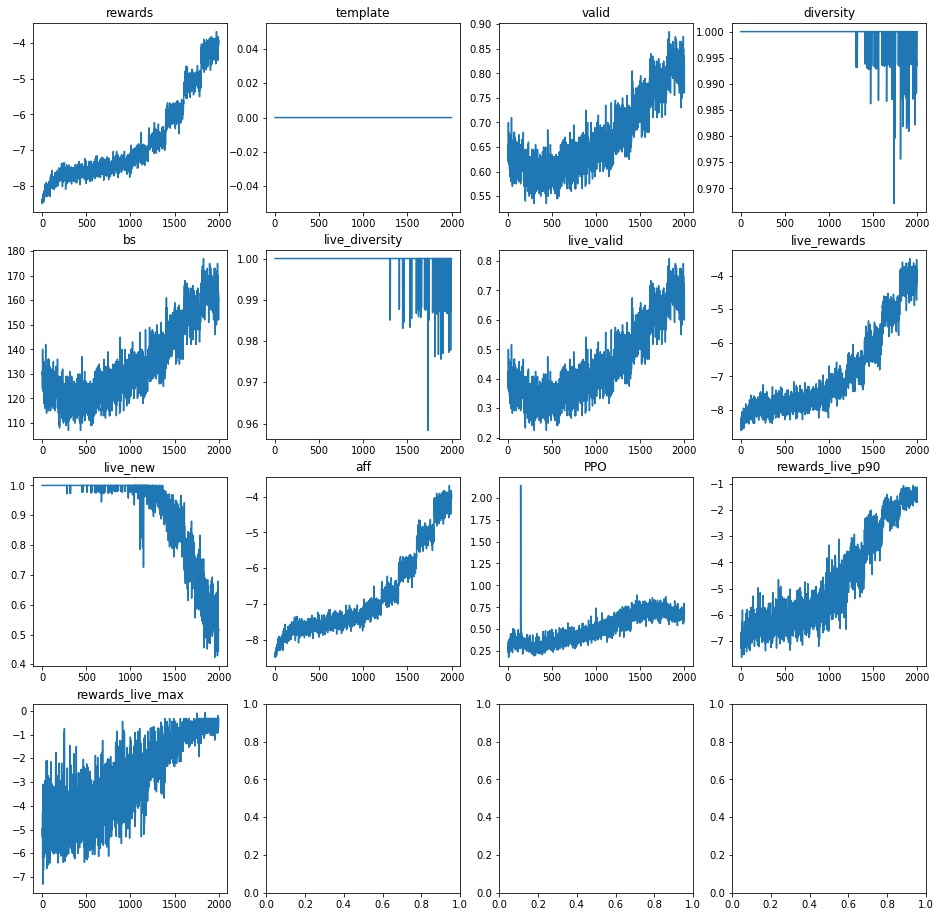

In [15]:
env.log.plot_metrics()

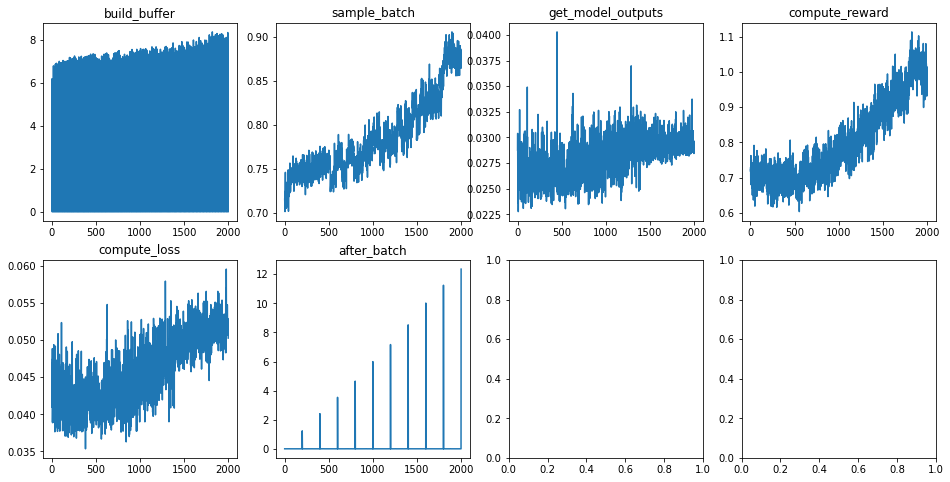

In [16]:
env.log.plot_timelog()

### LSTM LM

In [8]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Text_Dataset(['C'], vocab)
supervised_loss = CrossEntropy()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

model = LSTM_LM(d_vocab, 
                d_embedding,
                d_hidden, 
                n_layers,
                input_dropout,
                lstm_dropout,
                bos_idx, 
                bidir, 
                tie_weights)

model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_zinc.pt'))

<All keys matched successfully>

In [9]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':1e-4},
                       base_update_iter=5, base_update=.97)

In [10]:
gen_bs = 1500

sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0.6, gen_bs)
sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('rewards', 10, 95, 100)
sampler4 = TokenSwapSampler('rewards', 10, 95, 100, vocab, 0.1)

samplers = [sampler1, sampler2, sampler3, sampler4]

In [11]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [supervised_cb, live_p90, live_max]

In [12]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[aff_reward], loss_cbs=[loss],
                 cbs=cbs)

In [14]:
env.fit(200, 90, 2000, 10)

iterations,rewards,template,valid,diversity,bs,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
0,-8.519,0.000,0.595,1.000,119,1.000,0.325,-8.584,1.000,-8.519,0.191,-7.745,-7.358
10,-8.199,0.000,0.595,1.000,119,1.000,0.325,-8.063,1.000,-8.199,0.236,-6.639,-5.566
20,-8.258,0.000,0.600,1.000,120,1.000,0.333,-8.408,1.000,-8.258,0.207,-7.005,-5.818
30,-7.957,0.000,0.605,1.000,121,1.000,0.342,-8.109,1.000,-7.957,0.321,-6.961,-5.706
40,-8.089,0.000,0.615,1.000,123,1.000,0.358,-8.117,1.000,-8.089,0.284,-6.621,-5.388
50,-8.079,0.000,0.585,1.000,117,1.000,0.308,-8.146,1.000,-8.079,0.299,-6.725,-5.173
60,-7.873,0.000,0.560,1.000,112,1.000,0.267,-8.078,1.000,-7.873,0.366,-6.728,-4.533
70,-7.733,0.000,0.590,1.000,118,1.000,0.317,-8.017,1.000,-7.733,0.468,-6.283,-5.513
80,-7.720,0.000,0.620,1.000,124,1.000,0.367,-7.420,1.000,-7.720,0.451,-5.383,-3.913
90,-7.835,0.000,0.615,1.000,123,1.000,0.358,-8.130,1.000,-7.835,0.380,-6.846,-5.547


Epoch,Train Loss,Valid Loss,Time
0,0.26264,0.26046,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.27230,0.20263,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.18378,0.19101,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.22701,0.17726,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.20071,0.18426,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.15546,0.16478,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.16675,0.17561,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.15528,0.17998,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.15482,0.14640,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.14517,0.15025,00:01


In [15]:
log_df = log_to_df(env.log.log)
log_df.drop_duplicates(subset='samples', inplace=True)

avg_reward = np.array(env.log.metrics['rewards'][-20:]).mean()
subset = log_df[(log_df.rewards>avg_reward) & (log_df.template>-5)]
print(subset.shape)

agent.model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_zinc.pt'))

agent.update_dataset_from_inputs(subset.samples.values)

agent.train_supervised(128, 2, 5e-5)

agent.base_model.load_state_dict(agent.model.state_dict())

(8252, 7)


Epoch,Train Loss,Valid Loss,Time
0,0.19560,0.19561,00:03
1,0.18816,0.18947,00:03


<All keys matched successfully>

In [16]:
env.fit(200, 90, 2000, 10)

iterations,rewards,template,valid,diversity,bs,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
2000,-3.295,0.000,0.830,0.994,166,1.000,0.717,-3.687,0.465,-3.295,0.955,-0.923,-0.141
2010,-3.569,0.000,0.810,0.994,162,0.988,0.683,-3.723,0.488,-3.569,1.255,-0.622,-0.045
2020,-3.963,0.000,0.850,1.000,170,1.000,0.750,-3.573,0.456,-3.963,1.125,-1.250,-0.409
2030,-3.927,0.000,0.815,1.000,163,1.000,0.692,-3.853,0.518,-3.927,1.084,-1.542,-0.478
2040,-3.533,0.000,0.835,0.982,167,0.977,0.725,-3.674,0.506,-3.533,1.078,-1.036,-0.564
2050,-3.702,0.000,0.825,0.994,165,1.000,0.708,-3.431,0.424,-3.702,1.157,-1.002,-0.478
2060,-3.623,0.000,0.845,0.994,169,1.000,0.742,-3.776,0.528,-3.623,1.179,-0.954,-0.045
2070,-3.923,0.000,0.800,1.000,160,1.000,0.667,-3.786,0.412,-3.923,1.239,-1.160,-0.141
2080,-3.854,0.000,0.815,1.000,163,1.000,0.692,-4.198,0.566,-3.854,1.164,-1.020,-0.141
2090,-3.486,0.000,0.845,0.994,169,0.989,0.742,-3.632,0.472,-3.486,0.986,-1.040,-0.141


Epoch,Train Loss,Valid Loss,Time
0,0.16136,0.16318,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.14451,0.14936,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.13534,0.13677,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.13313,0.12398,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.12609,0.12207,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.12315,0.13465,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.12953,0.12778,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.11928,0.11494,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.11465,0.11496,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.09842,0.11838,00:03


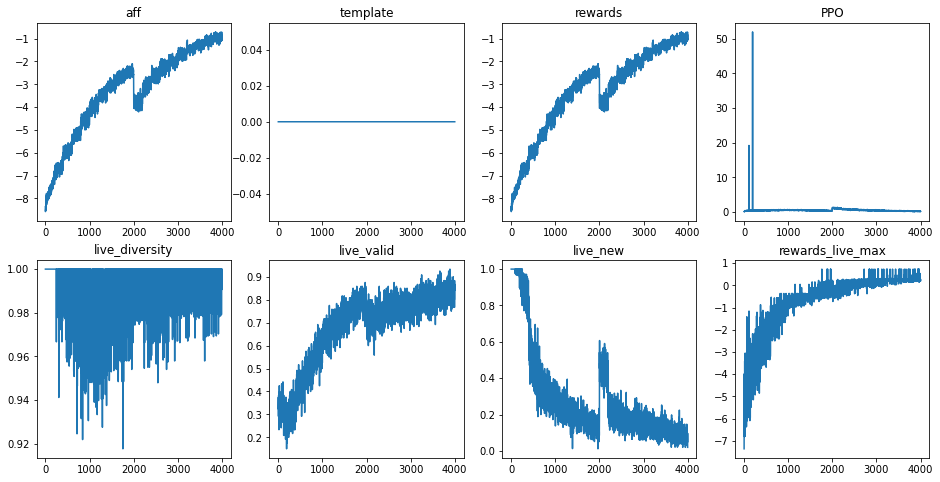

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(16,8))
plot_vals = ['aff', 'template', 'rewards', 'PPO',
             'live_diversity', 'live_valid', 'live_new', 'rewards_live_max']

for i, ax in enumerate(axes.flat):
    ax.plot(np.stack(env.log.metrics[plot_vals[i]]))
    ax.set_title(plot_vals[i])

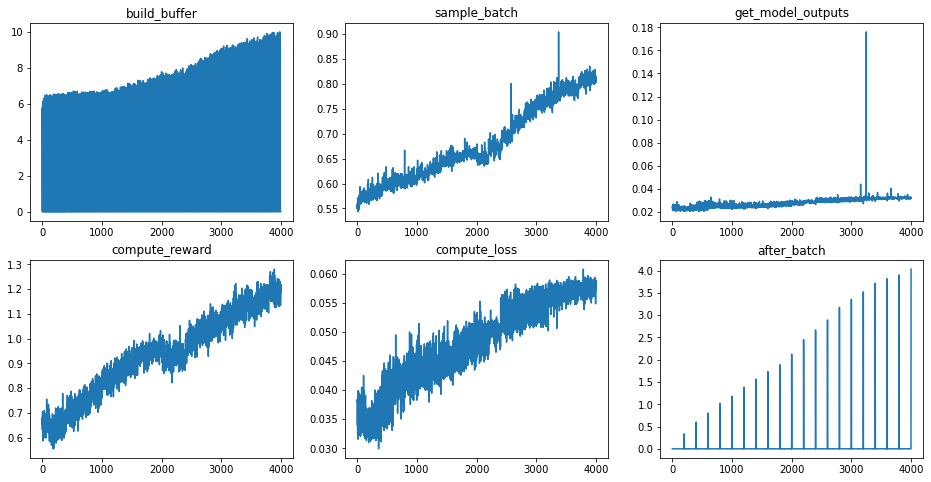

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(16,8))
plot_vals = ['build_buffer', 'sample_batch', 'get_model_outputs', 
             'compute_reward', 'compute_loss', 'after_batch']

for i, ax in enumerate(axes.flat):
    ax.plot(np.stack(env.log.timelog[plot_vals[i]]))
    ax.set_title(plot_vals[i])

### Conditional LSTM LM Latent Optimization

In [9]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Vec_To_Text_Dataset(['C'], vocab, ECFP6)
supervised_loss = CrossEntropy()


encoder = MLP_Encoder(2048, [1024, 512], 512, [0.1, 0.1])
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
condition_hidden = True
condition_output = False
bos_idx = vocab.stoi['bos']
norm_latent = True

model = Conditional_LSTM_LM(encoder, 
                               d_vocab, 
                               d_embedding, 
                               d_hidden, 
                               d_latent, 
                               n_layers,
                               input_dropout, 
                               lstm_dropout, 
                               norm_latent,
                               condition_hidden, 
                               condition_output, 
                               bos_idx)

model.load_state_dict(torch.load('../nbs/untracked_files/fp_cond_lstm_lm_zinc.pt'))

<All keys matched successfully>

In [10]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':1e-4},
                       base_update_iter=5, base_update=.97)

In [11]:
freeze(agent.model)

In [12]:
latents = torch.randn((400, 512))
gen_bs = 1500

sampler = LatentSampler(vocab, agent.model, latents, 'latent', 0, 1., gen_bs, opt_kwargs={'lr':1e-3})

samplers = [sampler]

In [13]:
live_max = MaxCallback('rewards', 'latent')
live_p90 = PercentileCallback('rewards', 'latent', 90)

cbs = [live_p90, live_max]

In [14]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[aff_reward], loss_cbs=[loss],
                 cbs=cbs)

In [15]:
env.fit(200, 90, 2000, 10)

iterations,rewards,template,valid,diversity,bs,latent_diversity,latent_valid,latent_rewards,latent_new,aff,PPO,rewards_latent_p90,rewards_latent_max
0,-8.362,0.000,0.400,1.000,80,1.000,0.400,-8.362,1.000,-8.362,0.204,-7.092,-6.016
10,-8.325,0.000,0.455,1.000,91,1.000,0.455,-8.325,0.978,-8.325,0.278,-6.784,-5.482
20,-8.519,0.000,0.435,1.000,87,1.000,0.435,-8.519,0.989,-8.519,0.211,-7.461,-5.029
30,-8.254,0.000,0.420,1.000,84,1.000,0.420,-8.254,0.976,-8.254,0.313,-6.841,-3.631
40,-8.403,0.000,0.430,1.000,86,1.000,0.430,-8.403,0.977,-8.403,0.221,-6.850,-5.428
50,-8.417,0.000,0.430,1.000,86,1.000,0.430,-8.417,0.953,-8.417,0.254,-7.191,-5.555
60,-8.144,0.000,0.385,1.000,77,1.000,0.385,-8.144,0.974,-8.144,0.194,-6.931,-5.381
70,-8.178,0.000,0.490,1.000,98,1.000,0.490,-8.178,0.959,-8.178,0.215,-7.067,-5.425
80,-8.343,0.000,0.405,1.000,81,1.000,0.405,-8.343,0.926,-8.343,0.186,-6.877,-5.760
90,-8.232,0.000,0.425,1.000,85,1.000,0.425,-8.232,0.976,-8.232,0.288,-6.858,-4.083


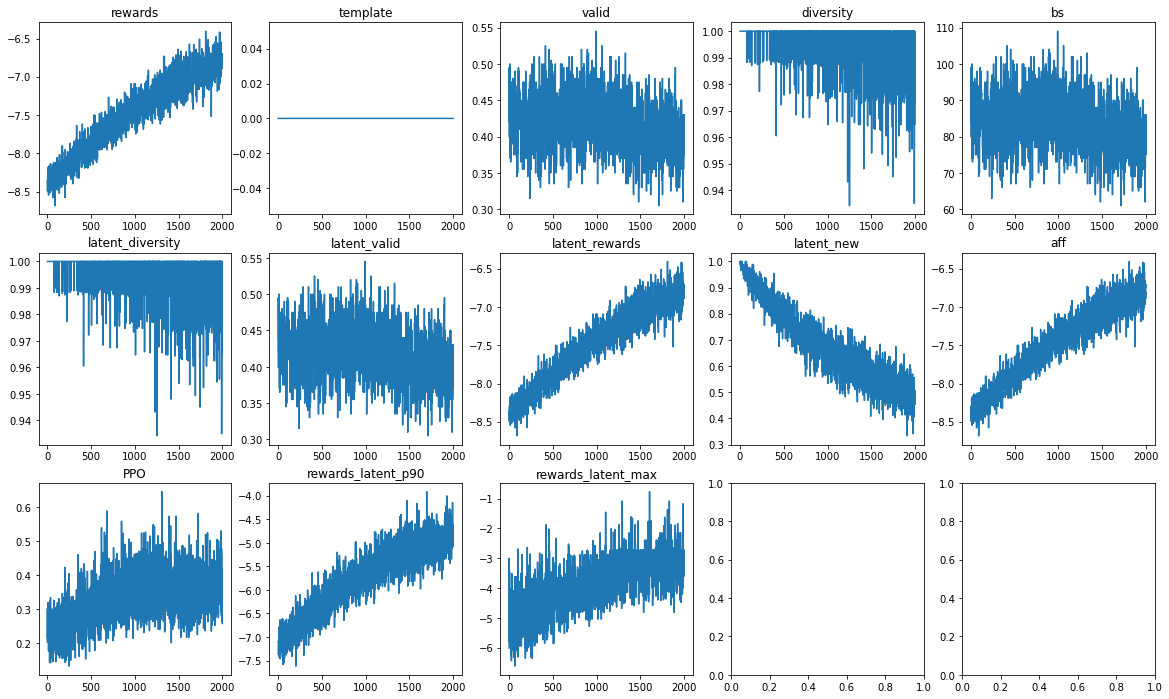

In [16]:
env.log.plot_metrics(cols=5)

### Conditional LSTM LM Prior Optimization

In [9]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Vec_To_Text_Dataset(['C'], vocab, ECFP6)
supervised_loss = CrossEntropy()


encoder = MLP_Encoder(2048, [1024, 512], 512, [0.1, 0.1])
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
condition_hidden = True
condition_output = False
bos_idx = vocab.stoi['bos']
norm_latent = True

model = Conditional_LSTM_LM(encoder, 
                               d_vocab, 
                               d_embedding, 
                               d_hidden, 
                               d_latent, 
                               n_layers,
                               input_dropout, 
                               lstm_dropout, 
                               norm_latent,
                               condition_hidden, 
                               condition_output, 
                               bos_idx)

model.load_state_dict(torch.load('../nbs/untracked_files/fp_cond_lstm_lm_zinc.pt'))

model.prior = SphericalPrior(torch.zeros((model.encoder.d_latent)), 
                                torch.zeros((model.encoder.d_latent)), 
                                trainable=True)

In [10]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':5e-3},
                       base_update_iter=5, base_update=.97)

In [11]:
freeze(agent.model.encoder)
freeze(agent.model.decoder)

In [12]:
gen_bs = 1500

sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0.6, gen_bs)
sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('rewards', 10, 95, 100)
sampler4 = TokenSwapSampler('rewards', 10, 95, 100, vocab, 0.1)

samplers = [sampler1, sampler2, sampler3, sampler4]

In [13]:
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [live_p90, live_max]

In [17]:
pl = PriorLoss(agent.model.prior, agent.model, 
               base_prior=agent.base_model.prior, clip=10.)

prior_loss = LossCallback(pl, 'prior_loss')
his_prior_loss = HistoricPriorLoss(pl, agent.dataset, 95, 400, 10, 5)


In [18]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[aff_reward], 
                  loss_cbs=[prior_loss, his_prior_loss], cbs=cbs)

In [19]:
env.fit(200, 90, 2000, 10)

iterations,rewards,template,valid,diversity,bs,live_diversity,live_valid,live_rewards,live_new,aff,prior_loss,hist_prior,rewards_live_p90,rewards_live_max
0,-8.392,0.000,0.685,1.000,137,1.000,0.475,-8.478,1.000,-8.392,0.000,0.000,-7.208,-5.829
10,-8.195,0.000,0.685,1.000,137,1.000,0.475,-8.134,1.000,-8.195,-0.019,0.000,-6.429,-5.515
20,-7.990,0.000,0.675,1.000,135,1.000,0.458,-8.237,1.000,-7.990,-0.119,-0.097,-6.546,-4.501
30,-8.085,0.000,0.645,1.000,129,1.000,0.408,-8.036,1.000,-8.085,-1.432,-1.250,-6.816,-4.924
40,-8.197,0.000,0.655,1.000,131,1.000,0.425,-8.250,1.000,-8.197,-1.836,-0.755,-7.361,-5.076
50,-8.011,0.000,0.665,1.000,133,1.000,0.442,-8.062,1.000,-8.011,-0.969,0.091,-6.348,-3.688
60,-8.023,0.000,0.635,1.000,127,1.000,0.392,-8.023,1.000,-8.023,-1.249,0.520,-6.762,-6.177
70,-8.015,0.000,0.650,1.000,130,1.000,0.417,-8.323,1.000,-8.015,-2.508,0.545,-7.110,-5.003
80,-7.990,0.000,0.645,1.000,129,1.000,0.408,-7.998,1.000,-7.990,-1.412,0.595,-6.267,-4.426
90,-8.107,0.000,0.630,1.000,126,1.000,0.383,-8.172,1.000,-8.107,-1.975,0.740,-6.999,-5.710


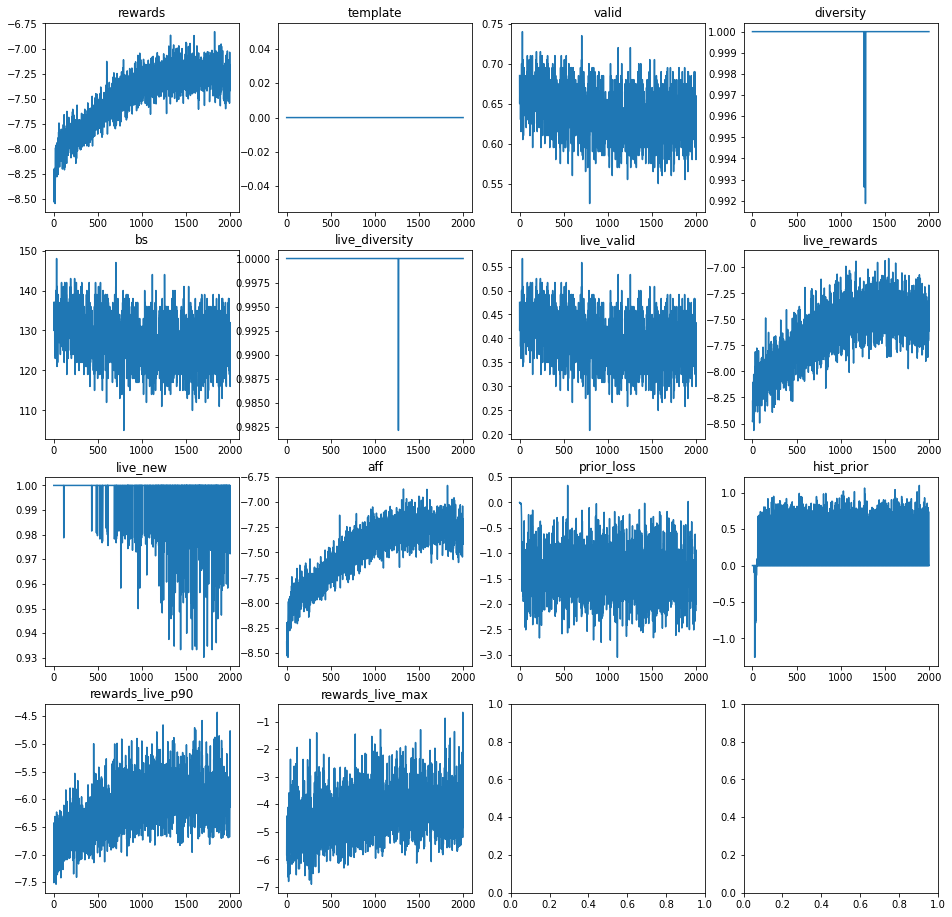

In [20]:
env.log.plot_metrics()

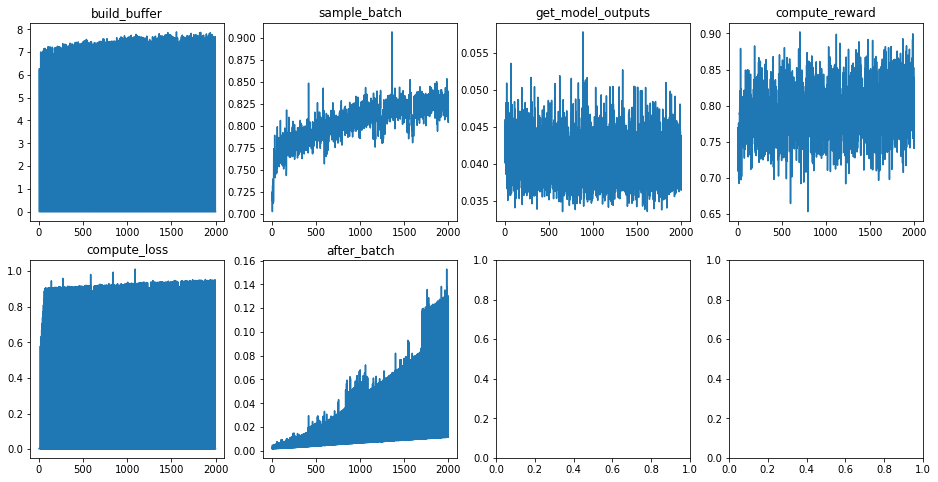

In [21]:
env.log.plot_timelog()

### Conditional LSTM LM Contrastive

In [8]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

# ds = Vec_To_Text_Dataset(['C'], vocab, ECFP6)
ds = Vec_To_Text_Dataset([('CCC', '')], vocab, partial(failsafe_fp, fp_function=ECFP6))
supervised_loss = CrossEntropy()


encoder = MLP_Encoder(2048, [1024, 512], 512, [0.1, 0.1])
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
condition_hidden = True
condition_output = False
bos_idx = vocab.stoi['bos']
norm_latent = True

model = Conditional_LSTM_LM(encoder, 
                               d_vocab, 
                               d_embedding, 
                               d_hidden, 
                               d_latent, 
                               n_layers,
                               input_dropout, 
                               lstm_dropout, 
                               norm_latent,
                               condition_hidden, 
                               condition_output, 
                               bos_idx)

model.load_state_dict(torch.load('../nbs/untracked_files/fp_cond_lstm_lm_zinc.pt'))

<All keys matched successfully>

In [9]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':1e-4},
                       base_update_iter=5, base_update=.97)

In [10]:
gen_bs = 1500

data_df = next(pd.read_csv('/home/dmai/smiles_datasets/shard_0.csv', chunksize=1000000))
sampler1 = DatasetSampler(data_df.smiles.values, 2000, 'zinc_data')
sampler1 = ContrastiveSampler(sampler1, vocab, ds, agent.model, gen_bs, repeats=5)

sampler2 = LogSampler('rewards', 50, 95, 500)

samplers = [sampler1, sampler2]

In [11]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)

cbs = [supervised_cb]

In [12]:
template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     RotBondFilter(None, 8),
                     ChargeFilter(None, 0)],
                    [], 
                    fail_score=-10., log=False)

sf = FPSimilarity(ECFP6, tanimoto_rd, 0.2, 0.95, 0.05, -1.)
template_cb = ContrastiveTemplate(sf, max_score=2., template=template, prefilter=True)

In [13]:
contrastive_reward = ContrastiveReward(aff_reward)

In [14]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[contrastive_reward], loss_cbs=[loss],
                 cbs=cbs)

In [16]:
env.fit(200, 90, 1000, 10)

iterations,rewards,template,template_temp,template_sim,valid,diversity,bs,aff,PPO
0,-0.031,0.050,0.000,0.050,1.000,1.000,200,-0.081,0.415
10,0.174,0.050,0.000,0.050,1.000,1.000,200,0.124,0.526
20,0.038,0.050,0.000,0.050,1.000,1.000,200,-0.012,1.463
30,-0.007,0.050,0.000,0.050,1.000,1.000,200,-0.057,0.644
40,-0.030,0.050,0.000,0.050,1.000,1.000,200,-0.080,0.702
50,0.075,0.050,0.000,0.050,1.000,1.000,200,0.025,0.749
60,0.549,0.050,0.000,0.050,1.000,1.000,200,0.499,0.880
70,0.536,0.050,0.000,0.050,1.000,1.000,200,0.486,1.518
80,0.425,0.050,0.000,0.050,1.000,1.000,200,0.375,2.301
90,0.681,0.050,0.000,0.050,1.000,1.000,200,0.631,6.855


Epoch,Train Loss,Valid Loss,Time
0,0.24638,0.27752,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.29310,0.27520,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.16840,0.20813,00:05


Epoch,Train Loss,Valid Loss,Time
0,0.18530,0.60183,00:06


Epoch,Train Loss,Valid Loss,Time
0,0.15968,0.15916,00:08


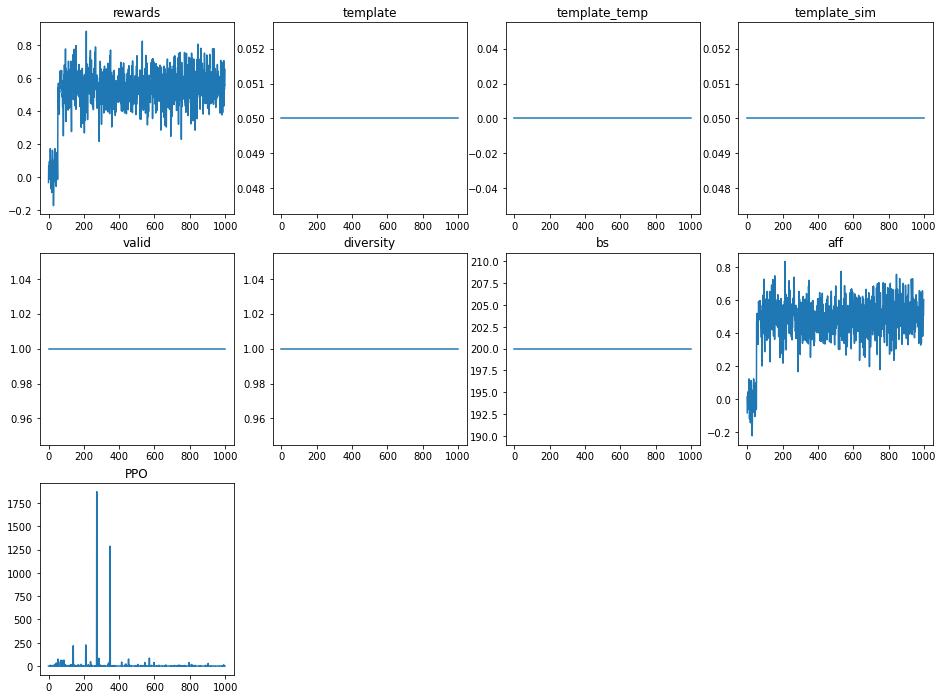

In [17]:
env.log.plot_metrics()

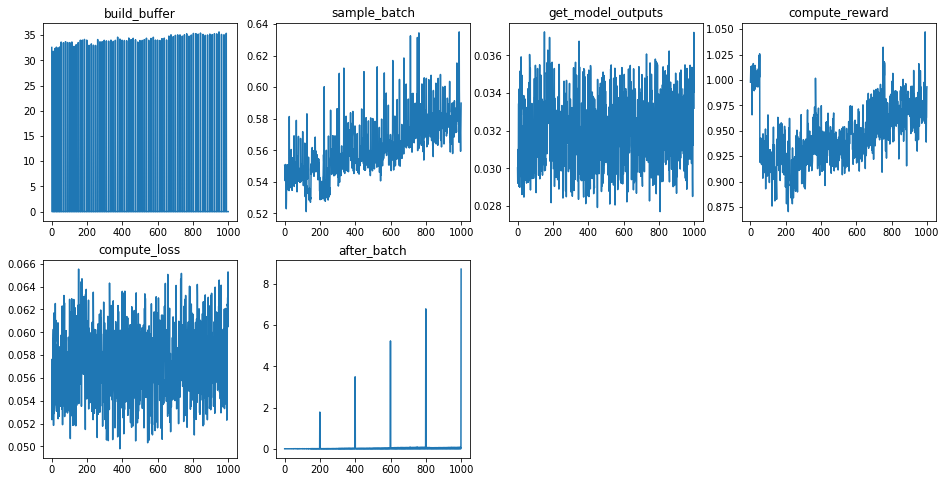

In [18]:
env.log.plot_timelog()

## LSTM R Group

In [5]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Text_Dataset(['C'], vocab)
supervised_loss = CrossEntropy()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

model = LSTM_LM(d_vocab, 
                d_embedding,
                d_hidden, 
                n_layers,
                input_dropout,
                lstm_dropout,
                bos_idx, 
                bidir, 
                tie_weights)

model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_rgroup.pt'))

<All keys matched successfully>

In [6]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':1e-4},
                       base_update_iter=5, base_update=.97)

In [5]:
reference = 'O=C(CCCCCCn1cc(-c2ccc3ncnc(Nc4cccc(Cl)c4F)c3c2)nn1)NO'
scaffold = '*c1ccc2ncnc(Nc3cccc(Cl)c3F)c2c1'

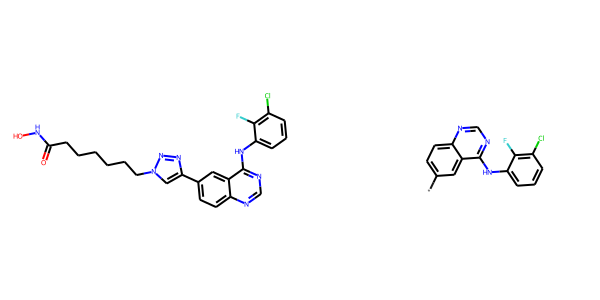

In [6]:
draw_mols(to_mols([reference, scaffold]))

In [7]:
r_template = Template(
                    [MolWtFilter(20, 200),
                     RingFilter(1,2)],
                    [],
                    fail_score=-1, log=True
                    )

smarts = ['[#6](=[#16])(-[#7])-[#7]',
        '[H]-[#6](-[H])=[#6]-[*]',
        '[#6]=[#6]=[#6]',
        '[#7][F,Cl,Br,I]',
        '[#6;!R]=[#6;!R]-[#6;!R]=[#6;!R]']



full_template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     RotBondFilter(None, 8),
                     HeteroatomFilter(None, 10),
                     ChargeFilter(None, 0),
                     MaxRingFilter(None, 6),
                     MinRingFilter(5, None),
                     HBDFilter(None, 5),
                     HBAFilter(None, 10),
                     MolWtFilter(None, 500),
                     LogPFilter(None, 5),
                     SAFilter(None, 7),
                     BridgeheadFilter(None,0),
                     PAINSAFilter(),
                     ExclusionFilter(smarts, criteria='any'),
                     RotChainFilter(None, 7)
                    ],
                    [], 
                    fail_score=-10., log=True, use_lookup=True)

template = RGroupBlockTemplate(scaffold, r_template, 
                                    full_molecule_template=full_template)

template_cb = TemplateCallback(template, prefilter=True)

In [13]:
# df = pd.read_csv('../../smiles_datasets/single_frags.csv')
# df = df[df.weight<175]

# os.environ['ncpus'] = '64'
# screened = template.recurse_fragments(df.smiles.values)
# os.environ['ncpus'] = '0'

# screened = [i for i in screened if i[2]]

# screened = [i[0] for i in screened]
# screened = [i.replace('[2*:1]', '*') for i in screened]

# screened = list(set(screened))

# df = pd.DataFrame(screened, columns=['smiles'])
# df.to_csv('rgroup_screened.csv', index=False)

In [14]:
df = pd.read_csv('rgroup_screened.csv')
agent.update_dataset_from_inputs(df.smiles.values)
agent.train_supervised(256, 3, 5e-5)
agent.base_model.load_state_dict(agent.model.state_dict())

Epoch,Train Loss,Valid Loss,Time
0,0.53633,0.46570,00:42
1,0.49056,0.46008,00:42
2,0.49433,0.45972,00:43


<All keys matched successfully>

In [15]:
gen_bs = 1500

sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0.6, gen_bs)
sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('rewards', 10, 95, 100)
sampler4 = TokenSwapSampler('rewards', 10, 95, 100, vocab, 0.1)

samplers = [sampler1, sampler2, sampler3, sampler4]

In [16]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [supervised_cb, live_p90, live_max]

In [17]:
aff_reward = FunctionReward(r_agent.predict_data, 
                            'aff', 
                            weight=-10.,
                           sample_name='samples_fused')

In [18]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[aff_reward], loss_cbs=[loss],
                 cbs=cbs)

In [19]:
%%time
env.fit(200, 45, 2000, 10)

iterations,rewards,template,valid,diversity,bs,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
0,-4.955,0.000,0.665,1.000,133,1.000,0.442,-4.855,1.000,-4.955,0.463,-3.016,-1.722
10,-4.802,0.000,0.630,1.000,126,1.000,0.383,-4.812,1.000,-4.802,0.652,-3.317,-1.809
20,-4.776,0.000,0.610,1.000,122,1.000,0.350,-4.985,0.952,-4.776,0.697,-2.997,-1.069
30,-4.665,0.000,0.650,1.000,130,1.000,0.417,-4.943,0.980,-4.665,0.595,-3.289,-2.741
40,-4.747,0.000,0.675,1.000,135,1.000,0.458,-4.874,0.982,-4.747,0.552,-3.143,-0.960
50,-4.685,0.000,0.655,1.000,131,1.000,0.425,-4.783,0.961,-4.685,0.547,-3.029,-2.292
60,-4.531,0.000,0.650,1.000,130,1.000,0.417,-4.625,0.940,-4.531,0.653,-2.702,-1.817
70,-4.607,0.000,0.645,1.000,129,1.000,0.408,-4.783,1.000,-4.607,0.567,-3.139,-1.580
80,-4.687,0.000,0.710,1.000,142,1.000,0.517,-5.053,0.968,-4.687,0.555,-3.330,-2.212
90,-4.587,0.000,0.705,1.000,141,1.000,0.508,-4.903,0.967,-4.587,0.636,-3.181,-2.239


Epoch,Train Loss,Valid Loss,Time
0,0.49130,0.52844,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.46136,0.45484,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.47442,0.43599,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.44701,0.45366,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.44485,0.41496,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.43826,0.40505,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.40561,0.46952,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.40111,0.42127,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.34950,0.37775,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.39511,0.40121,00:00


CPU times: user 7h 4min 22s, sys: 7min 37s, total: 7h 12min
Wall time: 30min 56s


In [23]:
log_df = log_to_df(env.log.log)
log_df.drop_duplicates(subset='samples', inplace=True)

avg_reward = np.array(env.log.metrics['rewards'][-20:]).mean()
subset = log_df[(log_df.rewards>avg_reward) & (log_df.template>-5)]
print(subset.shape)

agent.model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_rgroup.pt'))

agent.update_dataset_from_inputs(subset.samples.values)

agent.train_supervised(128, 3, 5e-5)

agent.base_model.load_state_dict(agent.model.state_dict())

(19080, 8)


Epoch,Train Loss,Valid Loss,Time
0,0.46039,0.46410,00:03
1,0.45188,0.43640,00:03
2,0.45019,0.43518,00:03


<All keys matched successfully>

In [24]:
%%time
env.fit(200, 45, 2000, 10)

iterations,rewards,template,valid,diversity,bs,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
2000,-2.698,0.000,0.830,1.000,166,1.000,0.717,-2.775,0.337,-2.698,0.568,-1.325,-0.404
2010,-2.898,0.000,0.840,1.000,168,1.000,0.733,-3.206,0.409,-2.898,0.513,-1.610,-0.031
2020,-2.779,0.000,0.850,0.994,170,1.000,0.750,-2.723,0.300,-2.779,0.475,-1.042,-0.288
2030,-2.866,0.000,0.820,0.994,164,1.000,0.700,-3.114,0.310,-2.866,0.603,-1.397,-0.493
2040,-3.177,0.000,0.820,1.000,164,1.000,0.700,-3.174,0.345,-3.177,0.774,-1.173,-0.461
2050,-2.947,0.000,0.815,1.000,163,1.000,0.692,-3.110,0.301,-2.947,0.550,-1.436,-0.288
2060,-2.883,0.000,0.865,1.000,173,1.000,0.775,-2.951,0.280,-2.883,0.519,-1.247,-0.229
2070,-2.876,0.000,0.865,1.000,173,1.000,0.775,-3.013,0.366,-2.876,0.527,-1.468,-0.367
2080,-2.929,0.000,0.830,1.000,166,1.000,0.717,-2.889,0.360,-2.929,0.642,-1.172,-0.500
2090,-2.909,0.000,0.875,0.994,175,1.000,0.792,-3.053,0.326,-2.909,0.557,-1.446,-0.197


Epoch,Train Loss,Valid Loss,Time
0,0.41406,0.40836,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.45160,0.41062,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.42520,0.38829,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.38059,0.36915,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.41170,0.39880,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.35189,0.38993,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.40908,0.37421,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.36323,0.39019,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.45775,0.37896,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.40625,0.41195,00:01


CPU times: user 7h 4min 42s, sys: 8min 52s, total: 7h 13min 34s
Wall time: 27min 8s


In [25]:
ref_reward = aff_reward._compute_reward([reference]).item()

In [27]:
log_df = env.log.df
log_df.drop_duplicates(subset='samples', inplace=True)
log_df[log_df.aff>ref_reward]

,samples,sources,rewards,template,samples_fused,aff,PPO
91,*C1CCC(NC(=O)C=CCO)C1,live,0.311801,0.0,O=C(C=CCO)NC1CCC(c2ccc3ncnc(Nc4cccc(Cl)c4F)c3c...,0.311801,4.740335
81,*Cc1nn(C)c2c1C(O)CCC2,live,0.004125,0.0,Cn1nc(Cc2ccc3ncnc(Nc4cccc(Cl)c4F)c3c2)c2c1CCCC2O,0.004125,2.383493
80,*Cc1ncnc(C(N)=O)c1Cl,live,-0.030829,0.0,NC(=O)c1ncnc(Cc2ccc3ncnc(Nc4cccc(Cl)c4F)c3c2)c1Cl,-0.030829,0.814439
75,*Cc1n[nH]nc1C(N)=O,buffer,-0.006915,0.0,NC(=O)c1n[nH]nc1Cc1ccc2ncnc(Nc3cccc(Cl)c3F)c2c1,-0.006915,0.404582
107,*Cc1cnc(CO)c(C(N)=O)n1,live,0.058147,0.0,NC(=O)c1nc(Cc2ccc3ncnc(Nc4cccc(Cl)c4F)c3c2)cnc1CO,0.058147,0.202920
...,...,...,...,...,...,...,...
83,*Cc1ncn2c1CN(C)CC2C,live,0.048392,0.0,CC1CN(C)Cc2c(Cc3ccc4ncnc(Nc5cccc(Cl)c5F)c4c3)n...,0.048392,-0.604783
87,*Cc1nn(C)c2c1N=CC(O)C2C,live,-0.015085,0.0,CC1c2c(c(Cc3ccc4ncnc(Nc5cccc(Cl)c5F)c4c3)nn2C)...,-0.015085,-0.775945
104,*Cc1nn(C)c2c1CC(O)C(O)=N2,live,0.021429,0.0,Cn1nc(Cc2ccc3ncnc(Nc4cccc(Cl)c4F)c3c2)c2c1N=C(...,0.021429,-0.846733
131,*Cc1nn(C)c2c1CC(CN)OC2,live,0.030327,0.0,Cn1nc(Cc2ccc3ncnc(Nc4cccc(Cl)c4F)c3c2)c2c1COC(...,0.030327,-0.783965


In [29]:
log_df[log_df.aff>0.5]

,samples,sources,rewards,template,samples_fused,aff,PPO
103,*Cc1ncn2c1COC(CO)C2O,live,0.589517,0.0,OCC1OCc2c(Cc3ccc4ncnc(Nc5cccc(Cl)c5F)c4c3)ncn2C1O,0.589517,-0.137129
109,*Cc1ncn2c1COC(N)C2O,live,0.550628,0.0,NC1OCc2c(Cc3ccc4ncnc(Nc5cccc(Cl)c5F)c4c3)ncn2C1O,0.550628,-0.016409
39,*Cc1nn(C)c2c1C(O)CC2N=C,buffer,0.566555,0.0,C=NC1CC(O)c2c(Cc3ccc4ncnc(Nc5cccc(Cl)c5F)c4c3)...,0.566555,-0.899629
79,*Cc1ncn2c1COC(CO)C2O,buffer,0.589517,0.0,OCC1OCc2c(Cc3ccc4ncnc(Nc5cccc(Cl)c5F)c4c3)ncn2C1O,0.589517,-0.587569


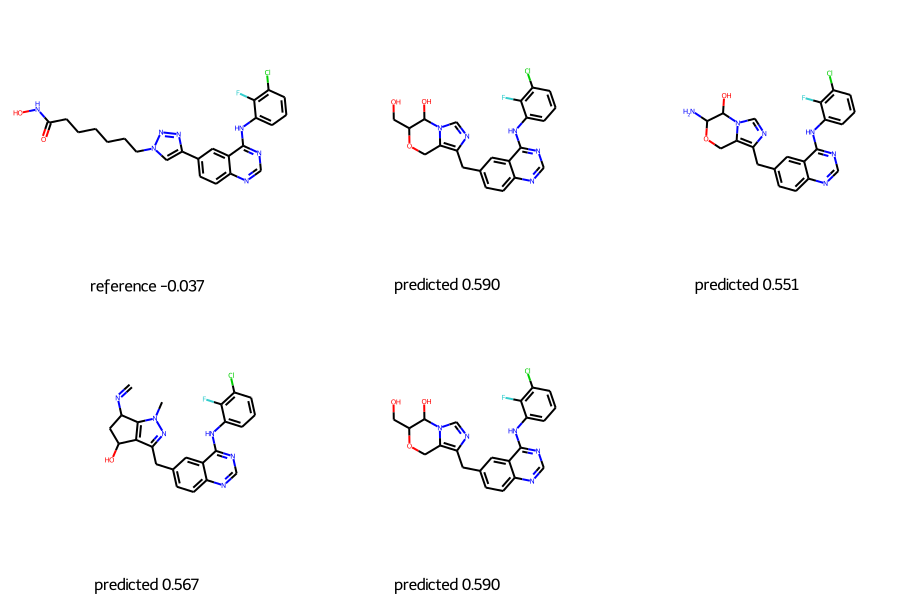

In [36]:
predicted = list(log_df[log_df.aff>0.5].samples_fused.values)
affinities = log_df[log_df.aff>0.5].aff.values
draw_mols(to_mols([reference]+ predicted),
         legends=[f'reference {ref_reward:.3f}']+[f'predicted {affinities[i]:.3f}' for i in range(len(predicted))])

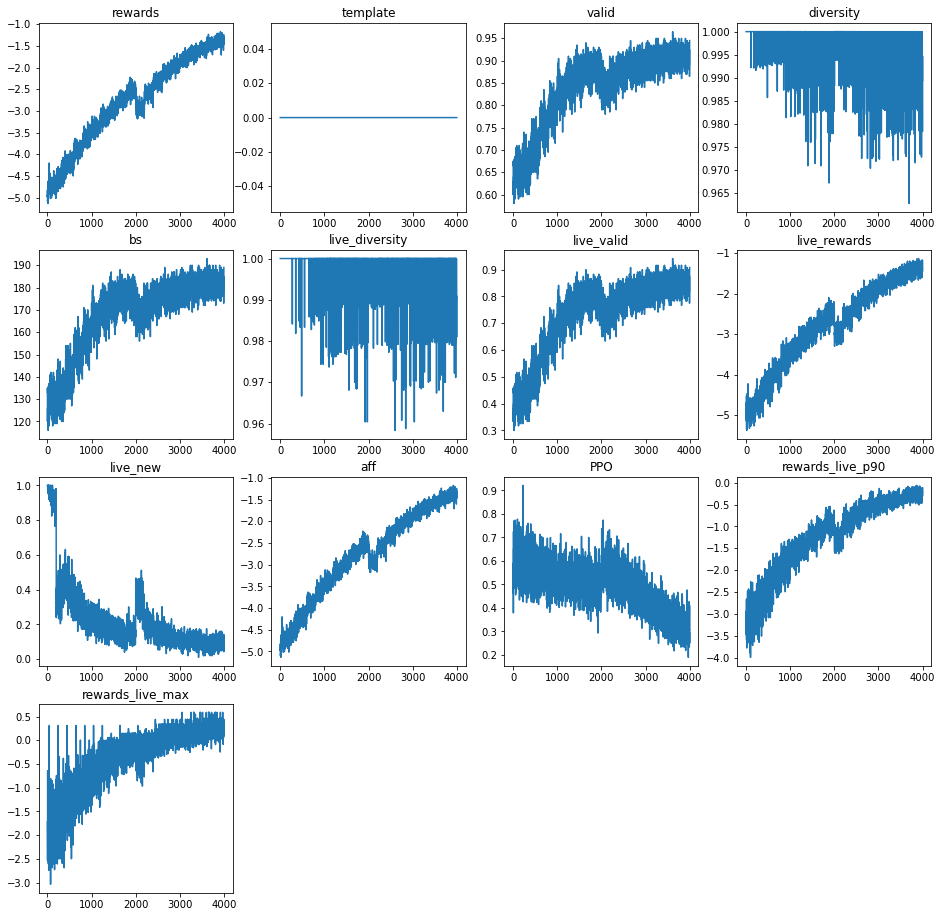

In [31]:
env.log.plot_metrics()

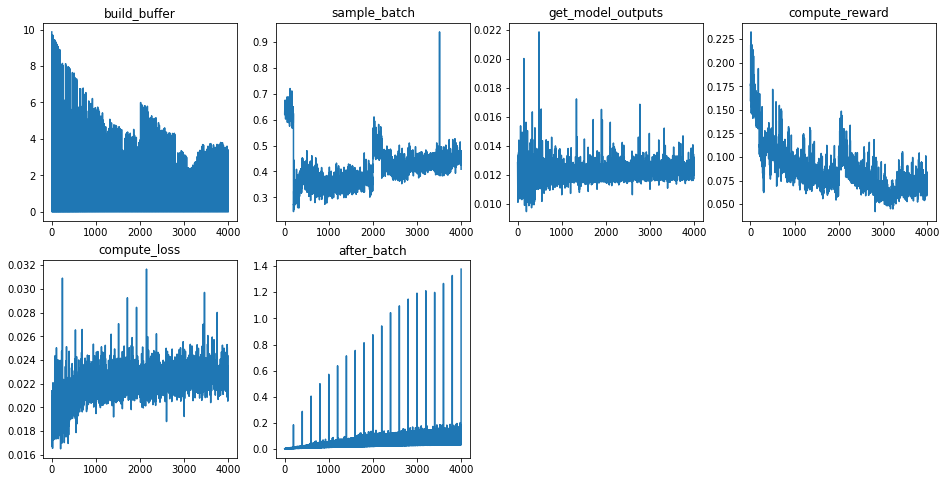

In [32]:
env.log.plot_timelog()